In [1]:
import os
parent_directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
grandparent_directory = os.path.abspath(os.path.join(parent_directory, os.pardir))
os.sys.path.append(grandparent_directory)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.graph_objects as go

from tools.data_formatting import get_smoothed_moving_all_data, get_common_indexes_n_recordings, smooth_tuning_curves_circularly
from tools.data_manager import get_all_experiments_runs, get_fovs_given_animal
from tools.alignment import procrustes, canoncorr
from global_vars import order_experiments, get_colors_for_each_experiment, animals, root_dir, experiments_to_exclude

# Load the sessions

In [2]:
### Load all sessions ###

animal = 'm120'
fov = 'fov1'
sessions = get_all_experiments_runs(animal, fov)
# Create a mapping of sessions and their chronological order
order_map = {value: index for index, value in enumerate(order_experiments)}
sessions = sorted(sessions, key=lambda x: order_map[x])

all_cells = []
all_tuning_curves = []
for (experiment, run) in sessions:
    _, _, phi, cells, tuning_curves, _ = get_smoothed_moving_all_data(animal, fov, experiment, run)
    all_cells.append(cells)
    all_tuning_curves.append(tuning_curves)

# Plot all tuning curves in the same space before alignment

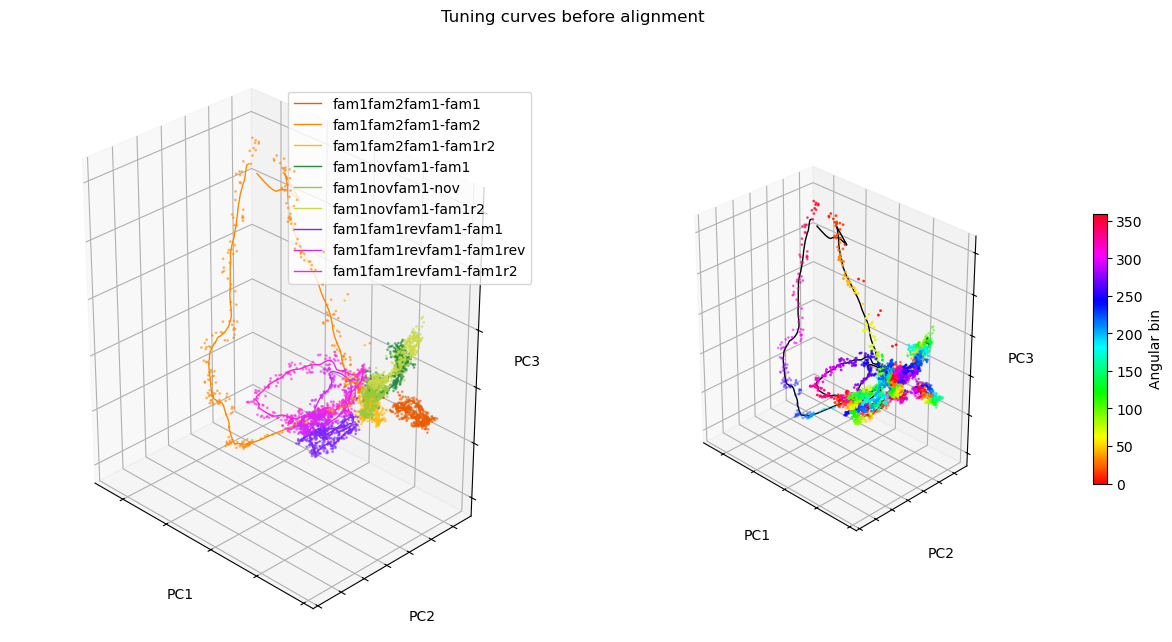

In [9]:
def plot_tuning_curves_pre_alignment(sessions, all_cells, all_tuning_curves, savefig=False, path=None):
    # Get the common cells and order all the tuning curves accordingly
    sel_cells_masks, ordered_cells = get_common_indexes_n_recordings(all_cells)
    # Remove the cells that are not common to all recordings
    sel_tuning_curves = [tuning_curves[:, mask] for tuning_curves, mask in zip(all_tuning_curves, sel_cells_masks)]
    # Order all the cells such that indexes correspond to the same cell across all recordings
    sel_tuning_curves = [tuning_curves[:, order] for tuning_curves, order in zip(sel_tuning_curves, ordered_cells)]

    # Concatenate all the tuning curves
    concatenated_tuning_curves = np.concatenate(sel_tuning_curves, axis=0)
    # Smooth the tuning curves
    smoothed_concatenated_tuning_curves = smooth_tuning_curves_circularly(concatenated_tuning_curves, 5)

    # Perform PCA on the concatenated tuning curves
    pca = PCA()
    pca_conc_tuning_curves = pca.fit_transform(smoothed_concatenated_tuning_curves)
    # Split the recordings again into separate sessions
    pca_tuning_curves = np.split(pca_conc_tuning_curves, len(sel_tuning_curves), axis=0)

    # Smooth the tuning curves
    smoothed_tuning_curves = [smooth_tuning_curves_circularly(tuning_curves, 20) for tuning_curves in pca_tuning_curves]

    colors = get_colors_for_each_experiment(sessions)
    # Interactive plot
    # # Plot them
    # fig = go.Figure()
    # for i in range(len(smoothed_tuning_curves)):
    #     fig.add_trace(go.Scatter3d(x=pca_tuning_curves[i][:, 0], y=pca_tuning_curves[i][:, 1], z=pca_tuning_curves[i][:, 2], 
    #                                mode='markers', marker=dict(size=2, color=colors[i], opacity=0.2), showlegend=False))
    #     fig.add_trace(go.Scatter3d(x=smoothed_tuning_curves[i][:, 0], y=smoothed_tuning_curves[i][:, 1], z=smoothed_tuning_curves[i][:, 2], 
    #                                mode='lines', line=dict(color=colors[i], width=5), name=f'{sessions[i][0]}-{sessions[i][1]}'))

    # fig.update_layout(title='Tuning curves before alignment')
    # fig.show()

    # Plot a static version
    fig = plt.figure(figsize=(15, 7))
    grid = plt.GridSpec(nrows=1, ncols=2)
    fig.suptitle('Tuning curves before alignment')
    # Color code by session
    ax = fig.add_subplot(grid[0, 0], projection='3d')
    for i in range(len(smoothed_tuning_curves)):
        ax.scatter(pca_tuning_curves[i][:, 0], pca_tuning_curves[i][:, 1], pca_tuning_curves[i][:, 2], color=colors[i], alpha=0.5, s=1)
        ax.plot(smoothed_tuning_curves[i][:, 0], smoothed_tuning_curves[i][:, 1], smoothed_tuning_curves[i][:, 2], color=colors[i], linewidth=1, label=f'{sessions[i][0]}-{sessions[i][1]}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    # Rotate the view
    ax.view_init(azim=135, elev=30)
    ax.set_aspect('equal')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.legend()
    # Color code by angular bin
    ax = fig.add_subplot(grid[0, 1], projection='3d')
    for i in range(len(smoothed_tuning_curves)):
        im = ax.scatter(pca_tuning_curves[i][:, 0], pca_tuning_curves[i][:, 1], pca_tuning_curves[i][:, 2], c=np.arange(pca_tuning_curves[i].shape[0]), cmap='hsv', s=1)
        ax.plot(smoothed_tuning_curves[i][:, 0], smoothed_tuning_curves[i][:, 1], smoothed_tuning_curves[i][:, 2], color='black', linewidth=1)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.view_init(azim=135, elev=30)
    ax.set_aspect('equal')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    # Create colorbar
    fig.colorbar(im, orientation='vertical', label='Angular bin', pad=0.15, shrink=0.5)

    if not savefig:
        plt.show()
    else:
        plt.savefig(path)
        plt.close('all')

plot_tuning_curves_pre_alignment(sessions, all_cells, all_tuning_curves, savefig=False)


# Plot all tuning curves after CCA

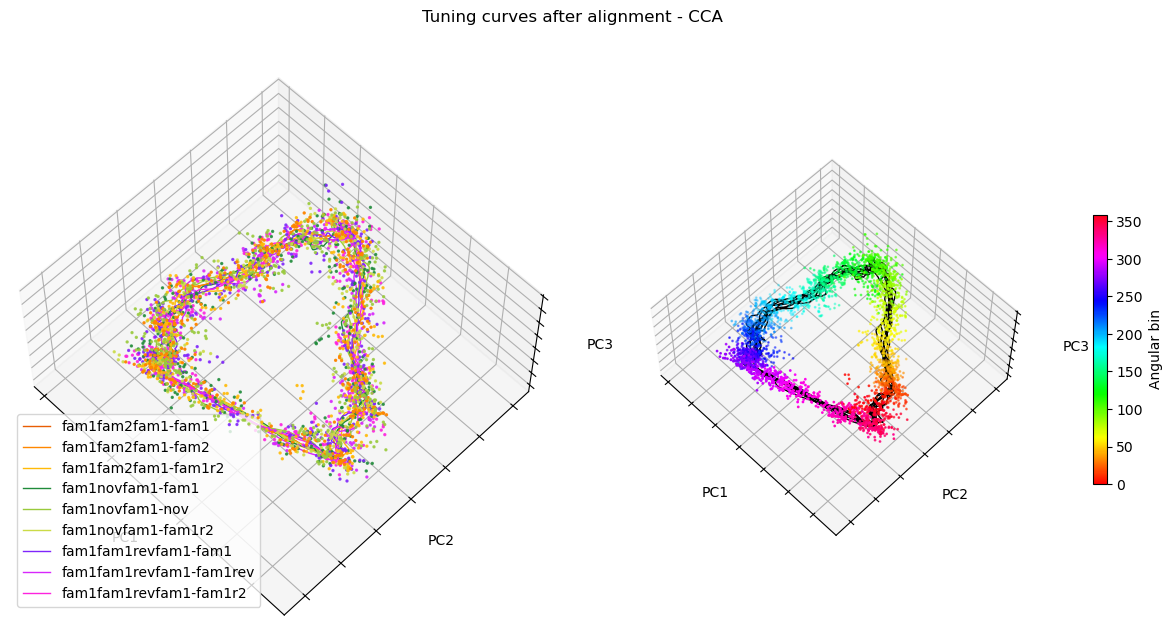

In [10]:
def plot_tuning_curves_post_alignment_cca(sessions, all_cells, all_tuning_curves, savefig=False, path=None):
    # Get the common cells and order all the tuning curves accordingly
    sel_cells_masks, ordered_cells = get_common_indexes_n_recordings(all_cells)
    # Remove the cells that are not common to all recordings
    sel_tuning_curves = [tuning_curves[:, mask] for tuning_curves, mask in zip(all_tuning_curves, sel_cells_masks)]
    # Order all the cells such that indexes correspond to the same cell across all recordings
    sel_tuning_curves = [tuning_curves[:, order] for tuning_curves, order in zip(sel_tuning_curves, ordered_cells)]
    # Smooth the tuning curves
    smoothed_sel_tuning_curves = [smooth_tuning_curves_circularly(tuning_curves, 5) for tuning_curves in sel_tuning_curves]

    # Take as a reference the first session 
    ref_experiment, ref_run = sessions[0]
    ref_tuning_curves = smoothed_sel_tuning_curves[0]
    pca = PCA(n_components=20)
    pca_ref_tuning_curves = pca.fit_transform(ref_tuning_curves)

    # Variables to save the embeddings
    all_tuning_curves_transformed = []
    for i, (experiment, run) in enumerate(sessions[1:]):
            tuning_curves = smoothed_sel_tuning_curves[i]
            pca_tuning_curves = pca.fit_transform(tuning_curves)
            A, B, r, _, cca_tuning_curves = canoncorr(pca_ref_tuning_curves, pca_tuning_curves, fullReturn=True)
            all_tuning_curves_transformed.append(cca_tuning_curves @ np.linalg.inv(A))
    # Save their smoothed version
    all_smoothed_tuning_curves = [smooth_tuning_curves_circularly(tuning_curves, kernel_size=20) for tuning_curves in all_tuning_curves_transformed]
    ref_smoothed_tuning_curves = smooth_tuning_curves_circularly(pca_ref_tuning_curves, kernel_size=20)

    colors = get_colors_for_each_experiment(sessions)
    # Plot interactive version
    # fig = go.Figure()
    # # Add the reference trace
    # fig.add_trace(go.Scatter3d(x=ref_smoothed_tuning_curves[:, 0], y=ref_smoothed_tuning_curves[:, 1], z=ref_smoothed_tuning_curves[:, 2],
    #                            mode='lines', line=dict(color=colors[0], width=5), name=f'{ref_experiment}-{ref_run}'))
    # # Add al the aothers
    # for i in range(len(all_tuning_curves_transformed)):
    #     fig.add_trace(go.Scatter3d(x=all_tuning_curves_transformed[i][:, 0], y=all_tuning_curves_transformed[i][:, 1], z=all_tuning_curves_transformed[i][:, 2], 
    #                                mode='markers', marker=dict(size=2, color=colors[i+1], opacity=0.2), showlegend=False))
    #     fig.add_trace(go.Scatter3d(x=all_smoothed_tuning_curves[i][:, 0], y=all_smoothed_tuning_curves[i][:, 1], z=all_smoothed_tuning_curves[i][:, 2], 
    #                                mode='lines', line=dict(color=colors[i+1], width=5), name=f'{sessions[i+1][0]}-{sessions[i+1][1]}'))
    # # Add title
    # fig.update_layout(title='Tuning curves after alignment')
    # fig.show()

    # Plot a static version
    fig = plt.figure(figsize=(15, 7))
    grid = plt.GridSpec(nrows=1, ncols=2)
    fig.suptitle('Tuning curves after alignment - CCA')
    # Color code by session
    ax = fig.add_subplot(grid[0, 0], projection='3d')
    # Add the reference trace
    ax.scatter(pca_ref_tuning_curves[:, 0], pca_ref_tuning_curves[:, 1], pca_ref_tuning_curves[:, 2], color=colors[0], alpha=0.5, s=1)
    ax.plot(ref_smoothed_tuning_curves[:, 0], ref_smoothed_tuning_curves[:, 1], ref_smoothed_tuning_curves[:, 2], color=colors[0], linewidth=1, label=f'{ref_experiment}-{ref_run}')
    # Add al the aothers
    for i in range(len(all_tuning_curves_transformed)):
        ax.scatter(all_tuning_curves_transformed[i][:, 0], all_tuning_curves_transformed[i][:, 1], all_tuning_curves_transformed[i][:, 2], color=colors[i+1], alpha=0.8, s=2)
        ax.plot(all_smoothed_tuning_curves[i][:, 0], all_smoothed_tuning_curves[i][:, 1], all_smoothed_tuning_curves[i][:, 2], color=colors[i+1], linewidth=1, label=f'{sessions[i+1][0]}-{sessions[i+1][1]}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    # Rotate the view (set azimuth and elevation)
    ax.view_init(azim=135, elev=60)
    ax.set_aspect('equal')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.legend()
    # Color code by angular bin
    ax = fig.add_subplot(grid[0, 1], projection='3d')
    # Add the reference trace
    im = ax.scatter(pca_ref_tuning_curves[:, 0], pca_ref_tuning_curves[:, 1], pca_ref_tuning_curves[:, 2], c=np.arange(pca_ref_tuning_curves.shape[0]), cmap='hsv', s=1)
    ax.plot(ref_smoothed_tuning_curves[:, 0], ref_smoothed_tuning_curves[:, 1], ref_smoothed_tuning_curves[:, 2], color='black', linewidth=1)
    # Add al the others
    for i in range(len(all_smoothed_tuning_curves)):
        ax.scatter(all_tuning_curves_transformed[i][:, 0], all_tuning_curves_transformed[i][:, 1], all_tuning_curves_transformed[i][:, 2], c=np.arange(all_tuning_curves_transformed[i].shape[0]), cmap='hsv', s=1)
        ax.plot(all_smoothed_tuning_curves[i][:, 0], all_smoothed_tuning_curves[i][:, 1], all_smoothed_tuning_curves[i][:, 2], color='black', linewidth=1)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.view_init(azim=135, elev=60)
    ax.set_aspect('equal')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    # Create colorbar
    fig.colorbar(im, orientation='vertical', label='Angular bin', pad=0.15, shrink=0.5)

    if not savefig:
        plt.show()
    else:
        plt.savefig(path)
        plt.close('all')

plot_tuning_curves_post_alignment_cca(sessions, all_cells, all_tuning_curves, savefig=False)

# Plot all tuning curves after Procrustes

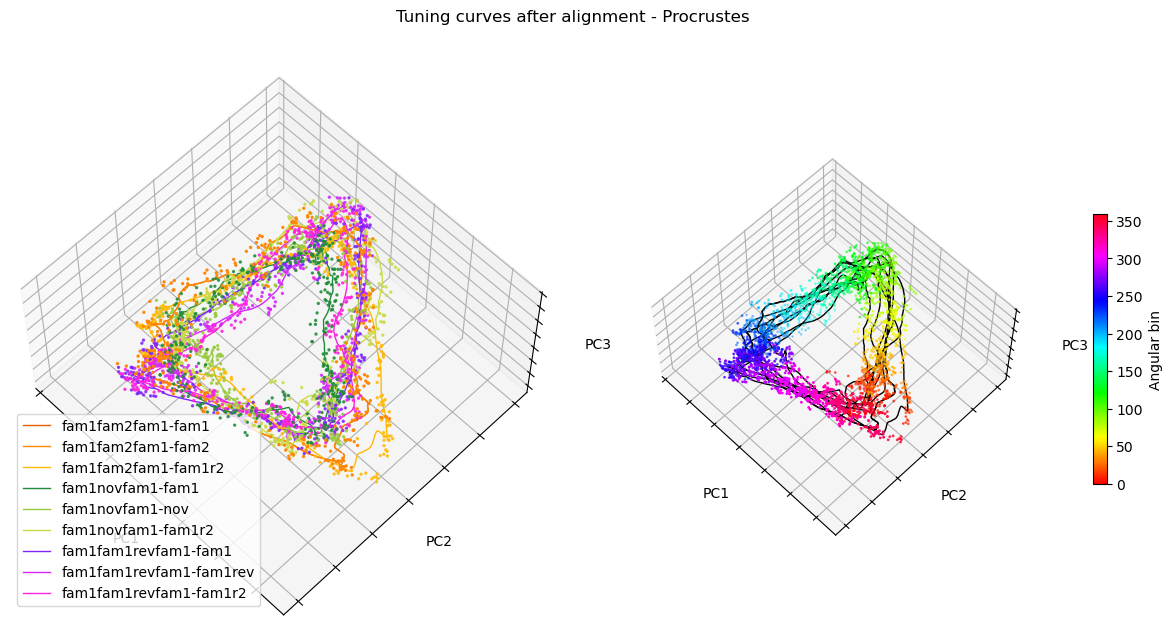

In [11]:
def plot_tuning_curves_post_alignment_procrustes(sessions, all_cells, all_tuning_curves, savefig=False, path=None):
    # Get the common cells and order all the tuning curves accordingly
    sel_cells_masks, ordered_cells = get_common_indexes_n_recordings(all_cells)
    # Remove the cells that are not common to all recordings
    sel_tuning_curves = [tuning_curves[:, mask] for tuning_curves, mask in zip(all_tuning_curves, sel_cells_masks)]
    # Order all the cells such that indexes correspond to the same cell across all recordings
    sel_tuning_curves = [tuning_curves[:, order] for tuning_curves, order in zip(sel_tuning_curves, ordered_cells)]
    # Smooth the tuning curves
    smoothed_sel_tuning_curves = [smooth_tuning_curves_circularly(tuning_curves, 5) for tuning_curves in sel_tuning_curves]

    # Take as a reference the first session 
    ref_experiment, ref_run = sessions[0]
    ref_tuning_curves = smoothed_sel_tuning_curves[0]
    pca = PCA(n_components=20)
    pca_ref_tuning_curves = pca.fit_transform(ref_tuning_curves)
    # Save their smoothed version
    all_smoothed_tuning_curves = [smooth_tuning_curves_circularly(tuning_curves, kernel_size=20) for tuning_curves in sel_tuning_curves[1:]]
    ref_smoothed_tuning_curves = smooth_tuning_curves_circularly(pca_ref_tuning_curves, kernel_size=20)

    # Variables to save the embeddings
    all_d = []
    all_tform = []
    all_tuning_curves_transformed = []
    for i, (experiment, run) in enumerate(sessions[1:]):
            tuning_curves = smoothed_sel_tuning_curves[i]
            pca_tuning_curves = pca.fit_transform(tuning_curves)
            d, pca_tuning_curves_transformed, tform = procrustes(pca_ref_tuning_curves, pca_tuning_curves)
            all_d.append(d)
            all_tform.append(tform)
            all_tuning_curves_transformed.append(pca_tuning_curves_transformed)
    # Save their smoothed version
    all_smoothed_tuning_curves = [smooth_tuning_curves_circularly(tuning_curves, kernel_size=20) for tuning_curves in all_tuning_curves_transformed]

    colors = get_colors_for_each_experiment(sessions)
    # Interactive plot
    # fig = go.Figure()
    # for i in range(len(all_tuning_curves_transformed)):
    #     fig.add_trace(go.Scatter3d(x=all_tuning_curves_transformed[i][:, 0], y=all_tuning_curves_transformed[i][:, 1], z=all_tuning_curves_transformed[i][:, 2], 
    #                                mode='markers', marker=dict(size=2, color=colors[i], opacity=0.2)))
    #     fig.add_trace(go.Scatter3d(x=all_smoothed_tuning_curves[i][:, 0], y=all_smoothed_tuning_curves[i][:, 1], z=all_smoothed_tuning_curves[i][:, 2], 
    #                                mode='lines', line=dict(color=colors[i], width=3)))
    # fig.show()

    # Plot a static version
    fig = plt.figure(figsize=(15, 7))
    grid = plt.GridSpec(nrows=1, ncols=2)
    fig.suptitle('Tuning curves after alignment - Procrustes')
    # Color code by session
    ax = fig.add_subplot(grid[0, 0], projection='3d')
    # Add the reference trace
    ax.scatter(pca_ref_tuning_curves[:, 0], pca_ref_tuning_curves[:, 1], pca_ref_tuning_curves[:, 2], color=colors[0], alpha=0.5, s=1)
    ax.plot(ref_smoothed_tuning_curves[:, 0], ref_smoothed_tuning_curves[:, 1], ref_smoothed_tuning_curves[:, 2], color=colors[0], linewidth=1, label=f'{ref_experiment}-{ref_run}')
    # Add al the aothers
    for i in range(len(all_tuning_curves_transformed)):
        ax.scatter(all_tuning_curves_transformed[i][:, 0], all_tuning_curves_transformed[i][:, 1], all_tuning_curves_transformed[i][:, 2], color=colors[i+1], alpha=0.8, s=2)
        ax.plot(all_smoothed_tuning_curves[i][:, 0], all_smoothed_tuning_curves[i][:, 1], all_smoothed_tuning_curves[i][:, 2], color=colors[i+1], linewidth=1, label=f'{sessions[i+1][0]}-{sessions[i+1][1]}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    # Rotate the view (set azimuth and elevation)
    ax.view_init(azim=135, elev=60)
    ax.set_aspect('equal')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.legend()
    # Color code by angular bin
    ax = fig.add_subplot(grid[0, 1], projection='3d')
    # Add the reference trace
    im = ax.scatter(pca_ref_tuning_curves[:, 0], pca_ref_tuning_curves[:, 1], pca_ref_tuning_curves[:, 2], c=np.arange(pca_ref_tuning_curves.shape[0]), cmap='hsv', s=1)
    ax.plot(ref_smoothed_tuning_curves[:, 0], ref_smoothed_tuning_curves[:, 1], ref_smoothed_tuning_curves[:, 2], color='black', linewidth=1)
    # Add al the others
    for i in range(len(all_smoothed_tuning_curves)):
        ax.scatter(all_tuning_curves_transformed[i][:, 0], all_tuning_curves_transformed[i][:, 1], all_tuning_curves_transformed[i][:, 2], c=np.arange(all_tuning_curves_transformed[i].shape[0]), cmap='hsv', s=1)
        ax.plot(all_smoothed_tuning_curves[i][:, 0], all_smoothed_tuning_curves[i][:, 1], all_smoothed_tuning_curves[i][:, 2], color='black', linewidth=1)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.view_init(azim=135, elev=60)
    ax.set_aspect('equal')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    # Create colorbar
    fig.colorbar(im, orientation='vertical', label='Angular bin', pad=0.15, shrink=0.5)
    
    if not savefig:
        plt.show()
    else:
        plt.savefig(path)
        plt.close('all')

plot_tuning_curves_post_alignment_procrustes(sessions, all_cells, all_tuning_curves, savefig=False)

# For every animal plot the figures and save them

In [ ]:
for animal in animals:
    fovs = get_fovs_given_animal(animal)
    for fov in fovs:
        print(f'Processing {animal} - {fov}')
        # Load all the sessions
        sessions = get_all_experiments_runs(animal, fov)
        # Create a mapping of sessions and their chronological order
        order_map = {value: index for index, value in enumerate(order_experiments)}
        sessions = sorted(sessions, key=lambda x: order_map[x])

        all_cells = []
        all_tuning_curves = []
        for (experiment, run) in sessions:
            if (animal, fov, experiment, run) not in experiments_to_exclude:
                _, _, phi, cells, tuning_curves, _ = get_smoothed_moving_all_data(animal, fov, experiment, run)
                all_cells.append(cells)
                all_tuning_curves.append(tuning_curves)

        # Plot and save
        path_to_save = f'{root_dir}figures_chosen/fig2/fig2a/'
        # For each session make a folder
        if not os.path.exists(f'{path_to_save}{animal}_{fov}'):
            os.makedirs(f'{path_to_save}{animal}_{fov}')
        plot_tuning_curves_pre_alignment(sessions, all_cells, all_tuning_curves, savefig=True, path=f'{path_to_save}{animal}_{fov}/{animal}_{fov}_tuning_curves_pre_alignment.pdf')
        plot_tuning_curves_post_alignment_cca(sessions, all_cells, all_tuning_curves, savefig=True, path=f'{path_to_save}{animal}_{fov}/{animal}_{fov}_tuning_curves_post_alignment_cca.pdf')
        plot_tuning_curves_post_alignment_procrustes(sessions, all_cells, all_tuning_curves, savefig=True, path=f'{path_to_save}{animal}_{fov}/{animal}_{fov}_tuning_curves_post_alignment_procrustes.pdf')

Processing m62 - fov2
Processing m66 - fov1
Processing m70 - fov1
